In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    w[y != 0] = 1./(y[y != 0]**2)
    return w

def rmspe(yhat, y):
    return np.sqrt(np.mean( ToWeight(y) * (y - yhat)**2 ))

def rmspe_xgb(yhat, y):
    y = np.exp(y.get_label()) - 1
    yhat = np.exp(yhat) - 1
    return "rmspe", np.sqrt(np.mean(ToWeight(y) * (y - yhat)**2))

In [3]:
def showCorr(df):
    fig = plt.subplots(figsize = (10,10))
    sb.set(font_scale=1.5)
    sb.heatmap(df.corr(),square = True,cbar=True,annot=True,annot_kws={'size': 10})
    plt.show()

In [4]:
def plotItem(df, group, column, title='', label='', setFigure=True, size=3):
    if setFigure:
        plt.figure(figsize=(30, size))
        
    if title == '':
        title = column +' x '+ group
    plot = df.groupby(group)[column].max().plot(legend=True, marker='X', label=label+' max', title=title)
    plot = df.groupby(group)[column].mean().plot(legend=True, marker='o', label=label+' mean')
    plot = df.groupby(group)[column].min().plot(legend=True, marker='x', label=label+' min')  

In [5]:
features = ['Store', 'State', 'StoreType', 'Assortment', 'Holiday', 'Promo', 'Day', 'DayOfWeek', 'WeekOfMonth', 'Month',  'Year']
featuresTrain = features + ['Sales']

In [6]:
def excludeStoreMaintence(df):
    excludeStore = []
    for store in df.Store.unique():
        excludeStore.append({'Store': store, 'Exclude': df.loc[df.Store == store].Store.count() < 750})    
    df = pd.merge(df, pd.DataFrame(excludeStore), on='Store')
    return df.loc[df.Exclude == False]

In [7]:
monthStr = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

def checkPromoInterval(item):
    if isinstance(item['PromoInterval'],str) and item['MonthStr'] in item['PromoInterval']:
        return 1
    else:
        return 0

def changeFeatureSelection(df, features, checkOpen=False, removeStoreMaintence=False):
        
    for column in ['StoreType', 'Assortment', 'StateHoliday', 'State']:
        df[column] = df[column].replace(0,'0')
        labels = df[column].unique()
        map_labels = dict(zip(labels, range(0,len(labels))))
        df[column] = df[column].map(map_labels)       
    
    df['Holiday'] = (df.SchoolHoliday == 1) | (df.StateHoliday > 0)
    df['Holiday'] = df.Holiday.astype(int)
    
    Date = pd.DatetimeIndex(df.Date)
    df['Day'] = Date.day
    df['Month'] = Date.month
    df['Week'] = Date.week
    df['WeekOfMonth'] = (Date.day-1)/7+1
    df['WeekOfMonth'] = df['WeekOfMonth'].astype(int)
    df['Year'] = Date.year
    df['MonthStr'] = df.Month.map(monthStr)

    df['PromoMonth'] = df.apply(lambda item: checkPromoInterval(item), axis=1)
    df['Promo'] = (df.Promo == 1) | (df.PromoMonth == 1)
    df['Promo'] = df.Promo.astype(int)
        
    df['CompetitionDistance'] = np.where(df.CompetitionDistance == 0, 0, df.CompetitionDistance / 1000)     
    
    competitionOpenBase = 12*2013
    df['CompetitionOpen'] = np.where(df.CompetitionOpenSinceYear < 2013, 0, 12*df.CompetitionOpenSinceYear + df.CompetitionOpenSinceMonth - competitionOpenBase)
    
    if (checkOpen):
        df = df.loc[df.Open == 1] 
        
    if 'Customers' in df.columns:
        df = df.loc[df.Customers > 0]
        
    if 'Sales' in df.columns:
        df = df.loc[(df.Sales >= 1500) & (df.Sales <= 35000)]
        
    if (removeStoreMaintence):
        df = excludeStoreMaintence(df)
        
    for column in features:
        df[column] = df[column].astype(float)
    return df

In [8]:
train = pd.read_csv("../input/competicao-dsa-machine-learning-mar-2019/dataset_treino.csv")
test = pd.read_csv("../input/competicao-dsa-machine-learning-mar-2019/dataset_teste.csv")
store = pd.read_csv("../input/competicao-dsa-machine-learning-mar-2019/lojas.csv")
store_state = pd.read_csv("../input/store-states/store_states.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
store.fillna(0, inplace=True)
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [10]:
store = pd.merge(store, store_state, on='Store')
store['StateName'] = store['State']
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [11]:
train = changeFeatureSelection(train, features, True, True)
test = changeFeatureSelection(test, features)

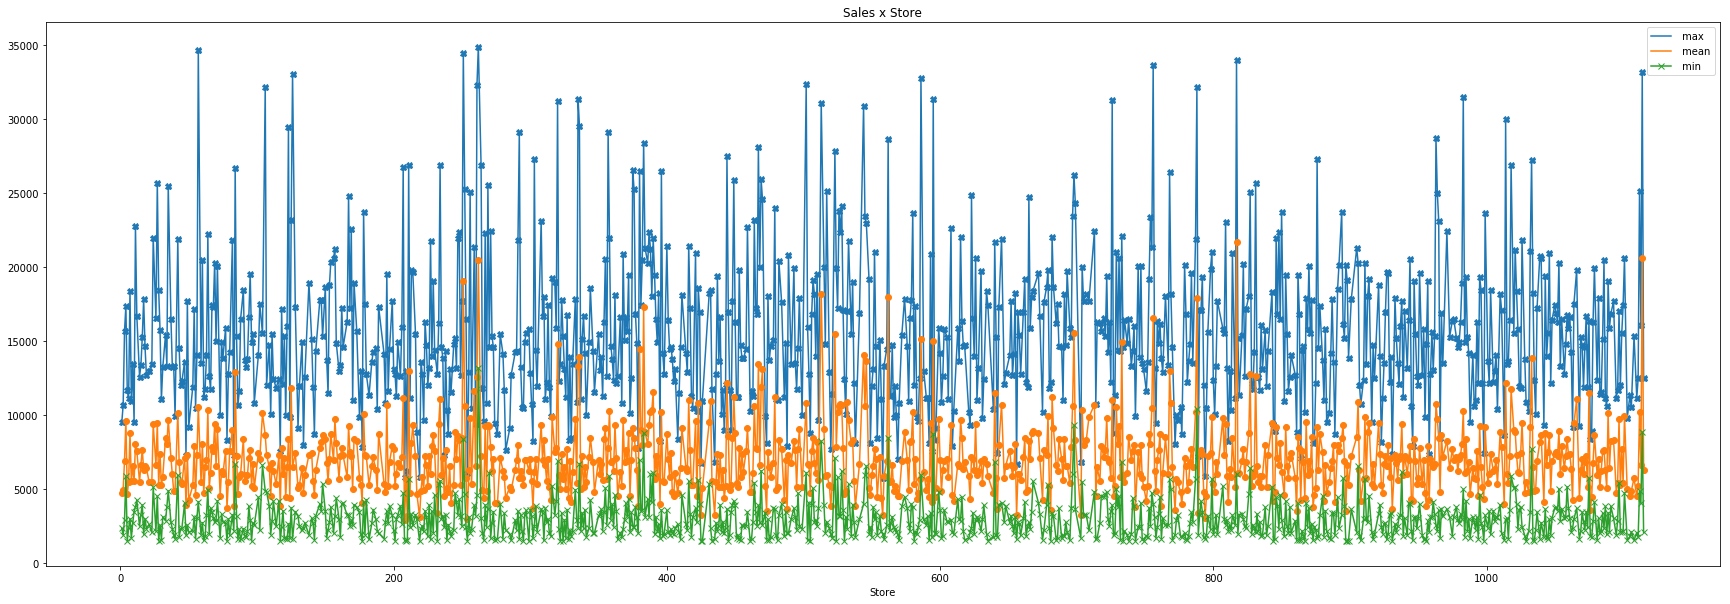

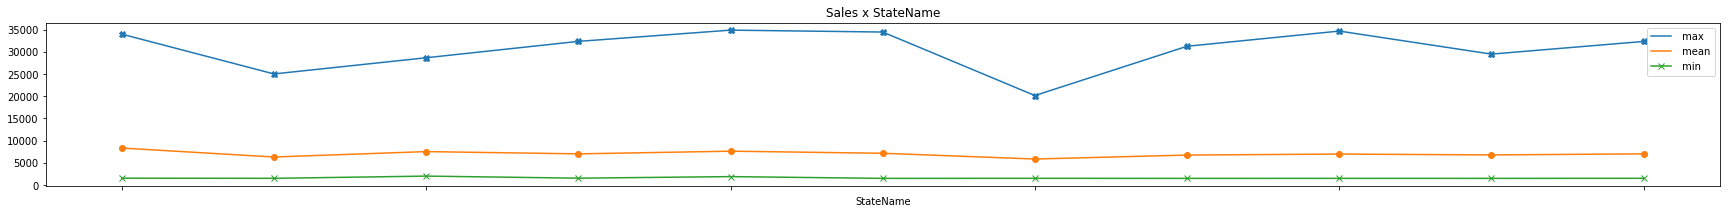

In [12]:
plotItem(train, 'Store', 'Sales', '', '', True, 10)
plotItem(train, 'StateName', 'Sales')

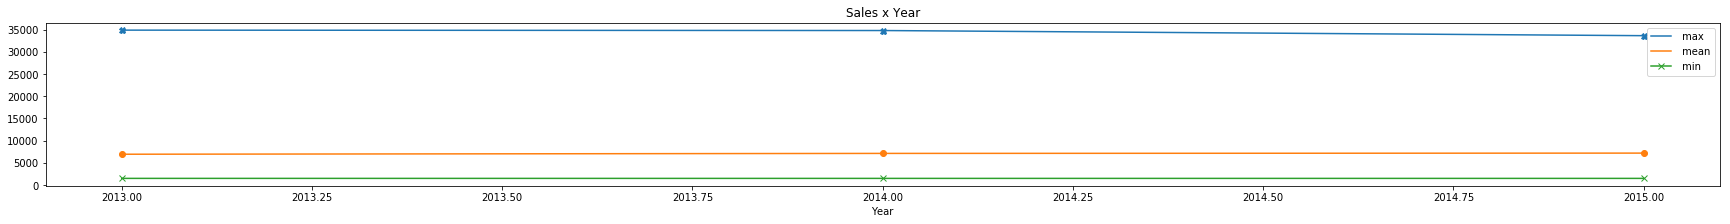

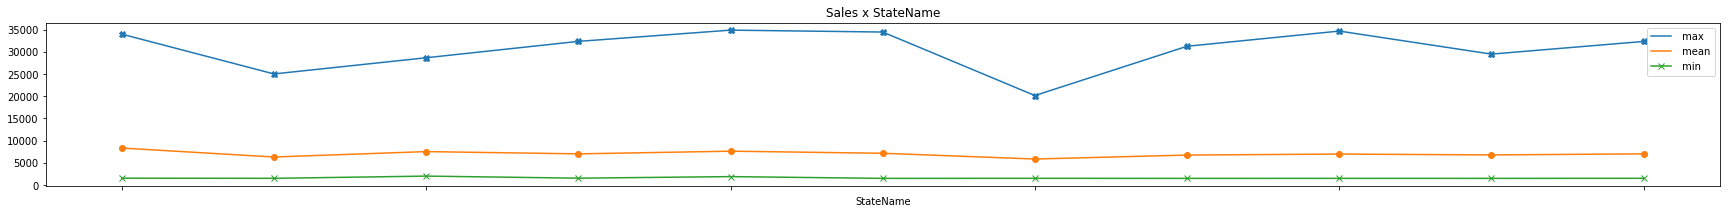

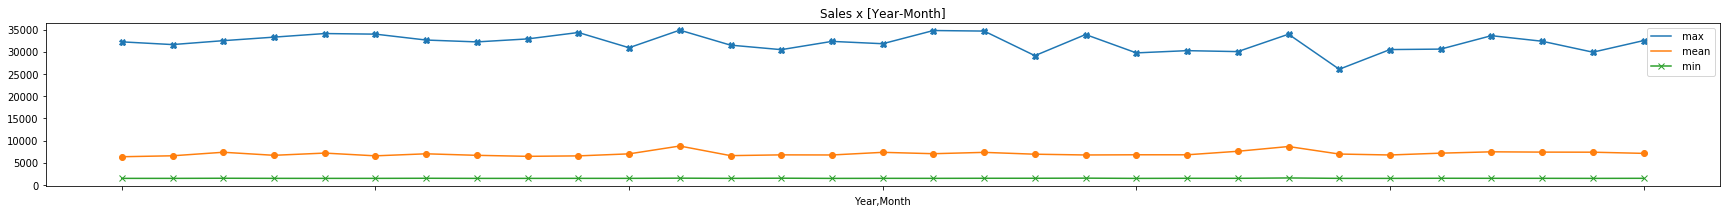

In [13]:
plotItem(train, 'Year', 'Sales')
plotItem(train, 'StateName', 'Sales')
plotItem(train, ['Year', 'Month'], 'Sales', 'Sales x [Year-Month]', '', True, 3)

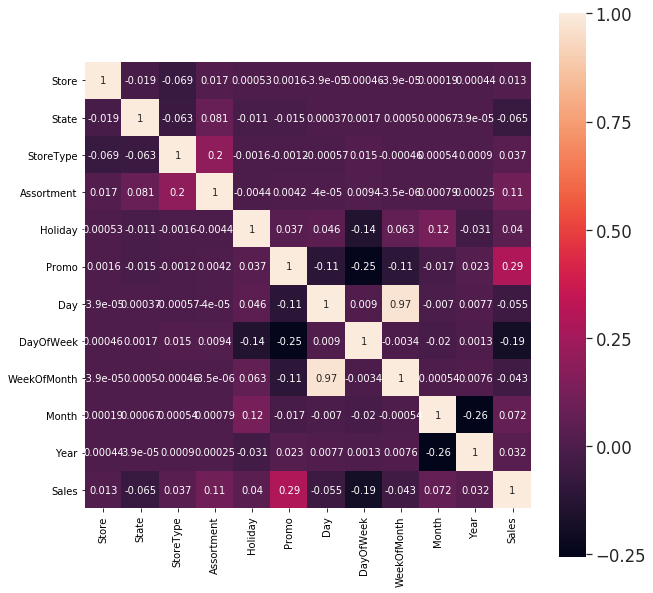

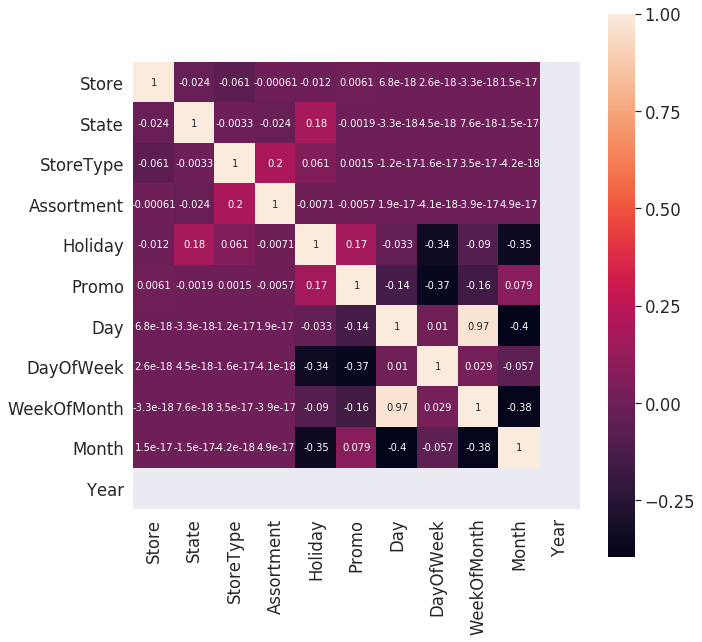

In [14]:
showCorr(train[featuresTrain])
showCorr(test[features])

In [15]:
params = {"objective": "reg:linear", "eta": 0.2, "max_depth": 10, "subsample": 0.7, "colsample_bytree": 0.7, "silent": 1}
num_rounds = 1000

In [16]:
X_train, X_test = train_test_split(train[featuresTrain], test_size=0.2, random_state=10)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train.Sales + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test.Sales + 1))
dtest = xgb.DMatrix(test[features])

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [17]:
evallist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_rounds, evals=evallist, early_stopping_rounds=100, feval=rmspe_xgb, verbose_eval=True)

[0]	train-rmse:6.63292	eval-rmse:6.63514	train-rmspe:0.998725	eval-rmspe:0.998728
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:5.31072	eval-rmse:5.31259	train-rmspe:0.994784	eval-rmspe:0.994795
[2]	train-rmse:4.25367	eval-rmse:4.25529	train-rmspe:0.984725	eval-rmspe:0.984752
[3]	train-rmse:3.4093	eval-rmse:3.41081	train-rmspe:0.964329	eval-rmspe:0.964387
[4]	train-rmse:2.73475	eval-rmse:2.73631	train-rmspe:0.930046	eval-rmspe:0.930162
[5]	train-rmse:2.19666	eval-rmse:2.19814	train-rmspe:0.880245	eval-rmspe:0.880433
[6]	train-rmse:1.76808	eval-rmse:1.76948	train-rmspe:0.816409	eval-rmspe:0.816677
[7]	train-rmse:1.42665	eval-rmse:1.42792	train-rmspe:0.742682	eval-rmspe:0.743005
[8]	train-rmse:1.15613	eval-rmse:1.15732	train-rmspe:0.663909	eval-rmspe:0.664309
[9]	train-rmse:0.940984	eval-rmse:0.942038	train-rmspe:0.585728	eval-rmspe:0.58617
[10]	train-rmse:0.773876	eval-rmse

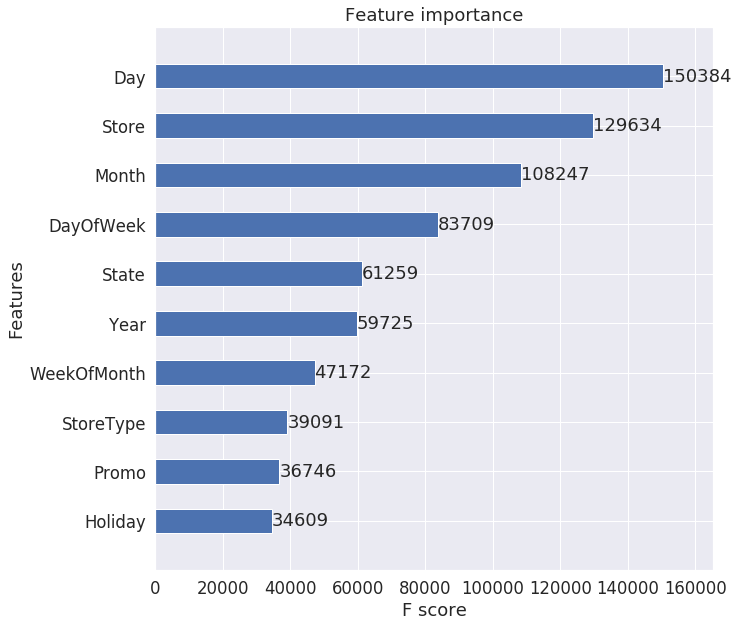

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features= 10, height=0.5, ax=ax)
plt.show()

In [19]:
predict = model.predict(xgb.DMatrix(X_test[features]))
predict[predict < 0] = 0
error = rmspe(np.exp(predict) - 1, X_test.Sales.values)
print('rmspe:', error)

rmspe: 0.09253432673938533


In [20]:
predict = model.predict(xgb.DMatrix(test[features]))
predict[test.Open==0] = 0

In [21]:
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(predict) - 1})
submission.Sales = submission.Sales.astype(int)
submission.sort_values('Id', inplace=True)
test['Sales'] = submission.Sales
submission.to_csv("submission.csv", index=False)

In [22]:
test = test.loc[test.Open == 1].copy()
train = train.loc[(train.Open == 1) & (train.Month >= test.Month.min()) & (train.Month <= test.Month.max())].copy()

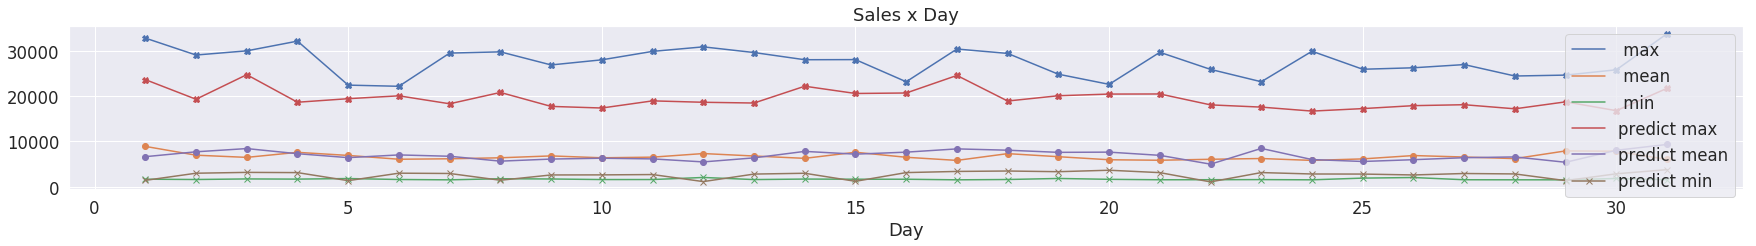

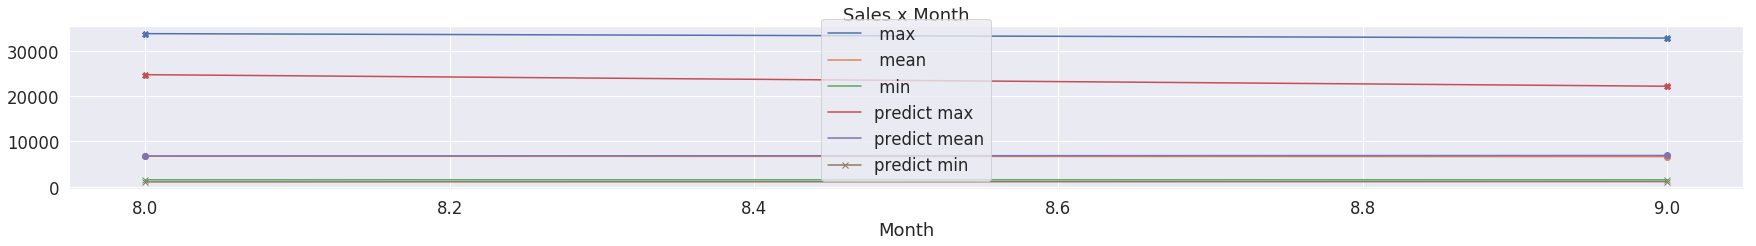

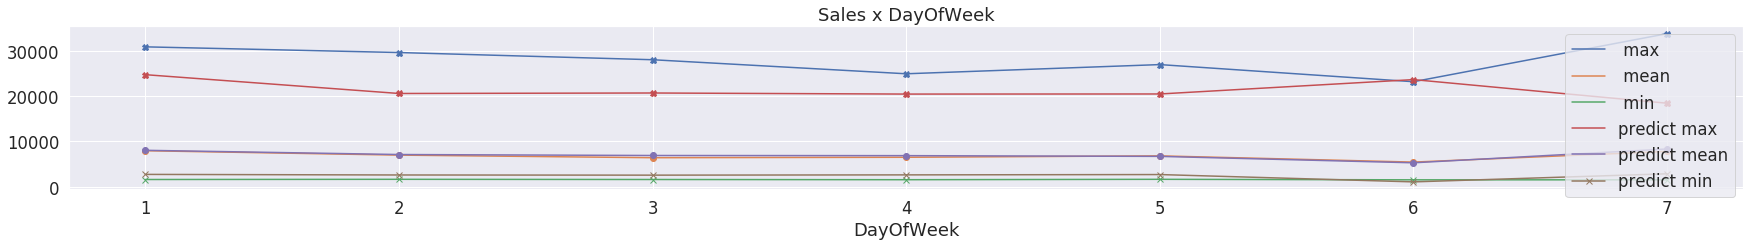

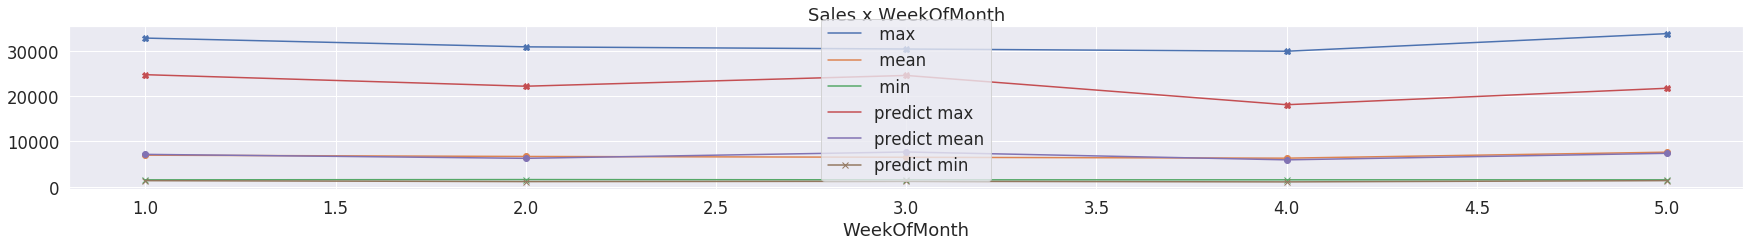

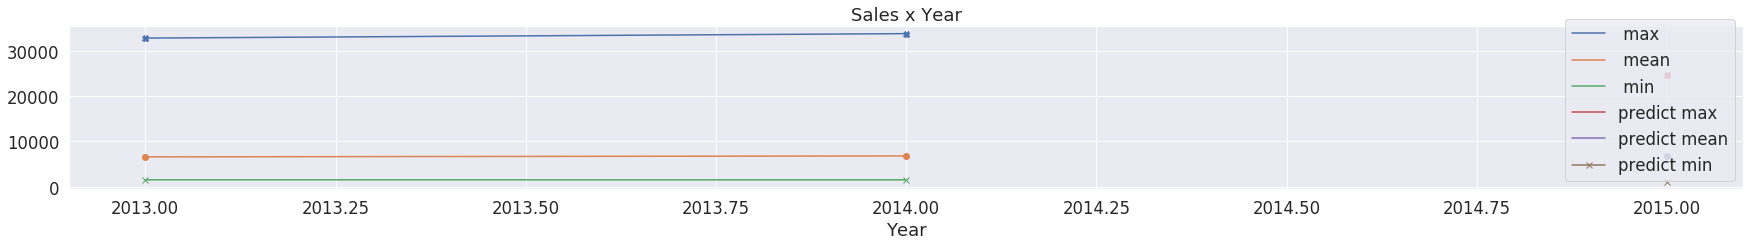

In [23]:
plotItem(train, 'Day', 'Sales')
plotItem(test, 'Day', 'Sales', '', 'predict', False)

plotItem(train, 'Month', 'Sales')
plotItem(test, 'Month', 'Sales', '', 'predict', False)

plotItem(train, 'DayOfWeek', 'Sales')
plotItem(test, 'DayOfWeek', 'Sales', '', 'predict', False)

plotItem(train, 'WeekOfMonth', 'Sales')
plotItem(test, 'WeekOfMonth', 'Sales', '', 'predict', False)

plotItem(train, 'Year', 'Sales')
plotItem(test, 'Year', 'Sales', '', 'predict', False)

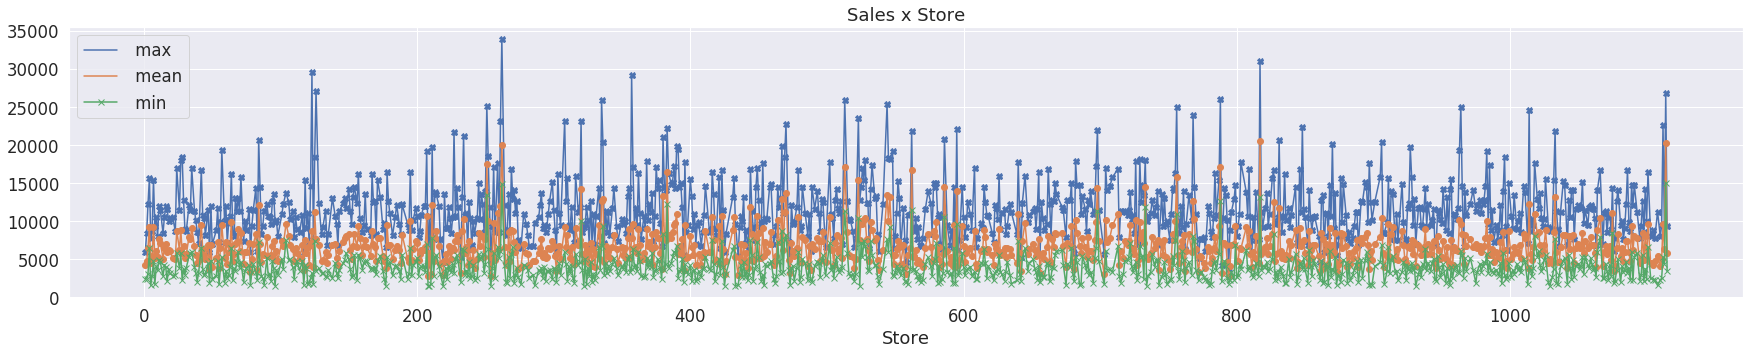

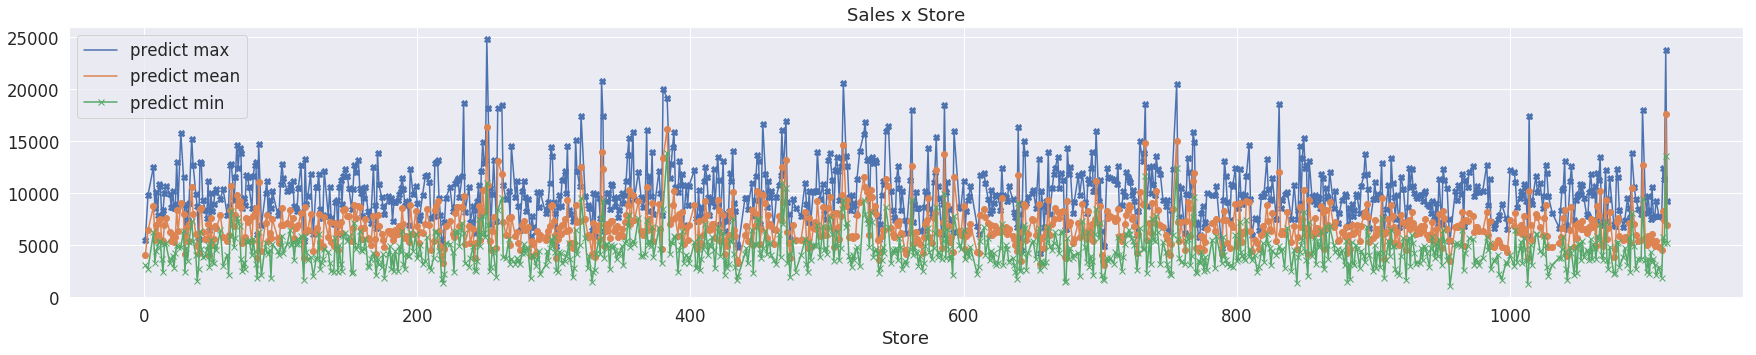

In [24]:
plotItem(train, 'Store', 'Sales', '', '', True, 5)
plotItem(test, 'Store', 'Sales', '', 'predict', True, 5)

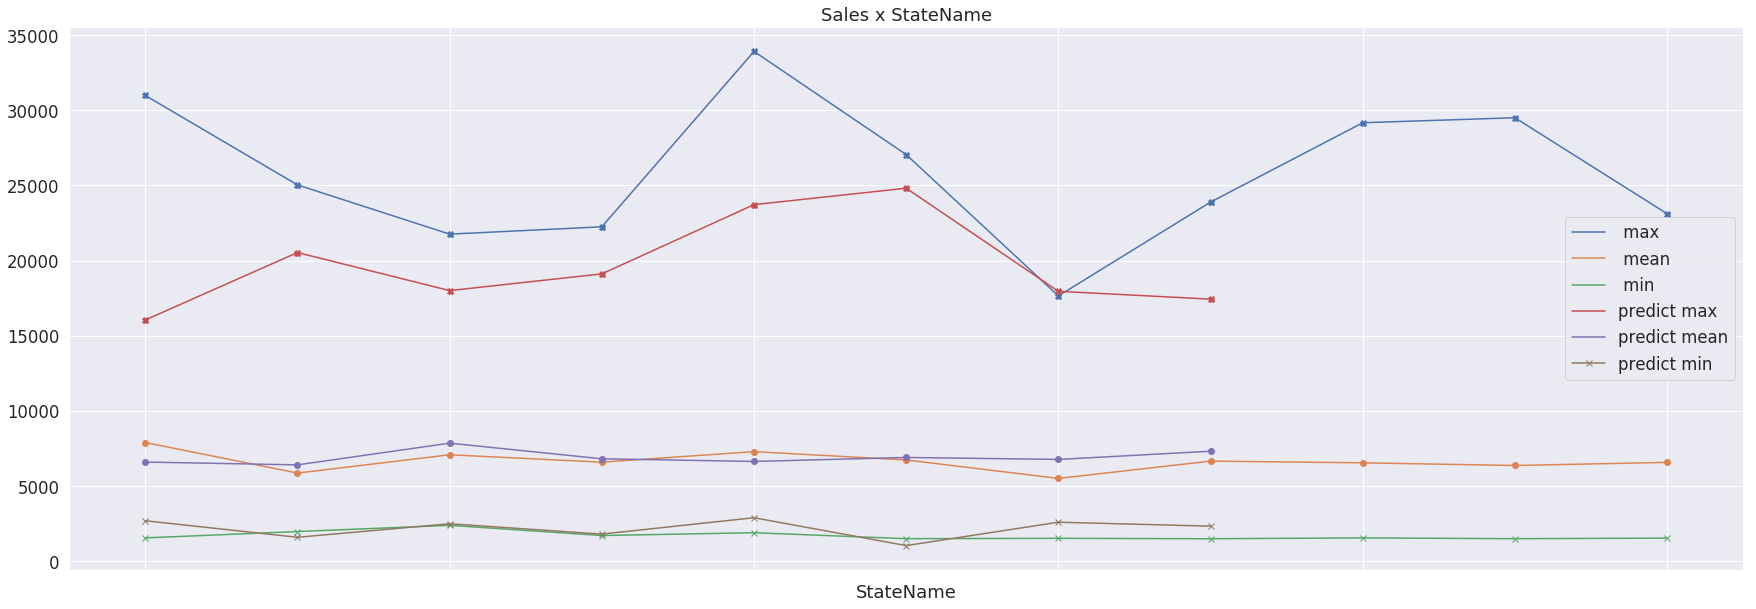

In [25]:
plotItem(train, 'StateName', 'Sales', '', '', True, 10)
plotItem(test, 'StateName', 'Sales', '', 'predict', False)